# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет на основании предоставленных исторические данных о поведении клиентов и расторжении договоров с банком.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [5]:
!pip install optuna

In [6]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [7]:
# Импортируем необходимые библиотеки
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
import optuna
from imblearn.over_sampling import SMOTE


# Импортируем библиотеки моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# Импортируем необходимые метрики
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, roc_curve

In [8]:
# Импортируем данные
data = pd.read_csv('/content/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [9]:
# Посмотрим информацию по данным
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Предобработка данных

Приведем названия столбцов к нижнему регистру

In [10]:
data.columns = data.columns.str.lower()
data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Имеются пропущенные значения в столбце **tenure**. Заменим их на нулевые значения

In [11]:
imputer = KNNImputer(n_neighbors=2)
data['tenure'] = imputer.fit_transform(data[['tenure']])

Проверим количество полных дубликатов

In [12]:
data.duplicated().sum()

0

Проверим уникальные значения в столбцах **geography** и **gender**

In [13]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [14]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

Со значениями в этих столбцах все в прорядке

Значения в столбце **customerid** должны быть уникальными в каждой строчке. Проверим на наличие дубликатов по этому столбцу

In [15]:
data['customerid'].duplicated().sum()

0

Дубликатов по данному столбцу не обнаружено, поэтому считаем, что каждая строчка - это уникальный пользователь

### Подготовка данных для машинного обучения

Проанализировав исходные данные, ясно, что часть данных не имеют ценности для машинного обучения и их можно удалить. Так столбец **rownumber** дублирует индексы датасета, **customerid** обозначает уникальный номер клиента, а столбец **surname** обозначает фамилию клиента. На прогнозирование целевого признака эти значения никак не влияют.

In [16]:
# создадим новый датасет на основании исходного, откуда удалим ненужные столбцы
data_ml = data.drop(['rownumber','customerid', 'surname'], axis=1)
data_ml.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В столбцах **geography** и **gender** имеются категориальные признаки, которые следует преобразовать в численные методом прямого кодирования (OHE)

In [17]:
data_ml = pd.get_dummies(data_ml, drop_first=True)
data_ml.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


В изначальном датасете, в столбце **geography** было 3 значения (Spain, Germany, France). В столбце **gender** было два значения (Male и Female). В результате преобразования у нас получилось 2 столбца от **geography** и 1 столбец от **gender**. Такми образом мы не попали в **дамми-ловушку**.

### Формирование выборок

Сформируем данные на три выборки:

+ обучающая (60%) - для обучения модели;


+ валидационная (20%) - для выбора наилучшего алгоритма;


+ тестовая (20%) - для финального теста.

In [18]:
# Сначала объявим признаки

features = data_ml.drop('exited', axis=1)
target = data_ml['exited']

In [19]:
# Разобьем данные на три выборки: 60% тренировочную, 20% валидационную, 20% тестовую
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=42, stratify=target_valid)

In [20]:
# Проверим правильность формирования

print('Тренировочные данные', features_train.shape, target_train.shape)
print('Валидационные данные', features_valid.shape, target_valid.shape)
print('Тестовые данные', features_test.shape, target_test.shape)

Тренировочные данные (6000, 11) (6000,)
Валидационные данные (2000, 11) (2000,)
Тестовые данные (2000, 11) (2000,)


### Масштабирование выборок

В столбцах **creditScore, age, tenure, balance, numofproducts, estimatedsalary** у нас имеются численные признаки. Масштабируем их методом стандартизации данных, чтобы алгоритм не решил, что какой-то из этих признаков важнее другого.

In [21]:
# Для масштабирования зафиксируем численные признаки
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

In [22]:
# Создадим объект этой структуры и настроим его на обучающих данных:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [23]:
# Масштабируем численные признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
6851,-1.283897,0.008566,1.449713,0.330105,0.783996,1,0,-0.084061,True,False,False
7026,0.271537,-1.139895,-0.002334,-1.220584,0.783996,0,1,0.264021,False,False,False
5705,-0.236571,0.104271,-0.001496,1.692794,0.783996,1,1,0.515344,True,False,True
9058,-1.874962,0.869911,-0.002334,1.032566,-0.919109,1,1,0.303842,False,True,False
9415,1.215167,0.391386,-1.089903,0.851257,0.783996,0,0,-1.400817,True,False,False


In [24]:
# Масштабируем численные признаки валидационной выборки
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
8583,-0.620245,-0.087139,-1.089903,1.060025,-0.919109,0,1,0.350332,False,False,False
1924,0.167842,0.487091,1.086910,0.739283,-0.919109,1,1,-0.134610,False,False,True
3195,0.478929,-0.948485,-1.815507,1.547344,-0.919109,0,0,0.736502,True,False,True
5263,1.640319,0.199976,-1.452705,0.056946,0.783996,1,0,1.152573,True,False,True
1484,2.065472,-0.948485,-1.452705,-1.220584,0.783996,1,1,1.715821,False,True,False


In [25]:
# Масштабируем численные признаки тестовой выборки
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
9167,-0.454332,-1.235600,-1.452705,-1.220584,-0.919109,1,0,-1.214912,False,False,True
9387,-1.315006,-0.661370,-1.452705,1.101480,-0.919109,0,0,1.537086,False,False,True
6859,0.852233,-0.087139,-0.727101,1.306360,-0.919109,0,0,-1.391960,False,False,False
3500,2.065472,-0.661370,-0.001496,0.483040,-0.919109,1,0,0.391177,False,False,False
6233,2.065472,-0.469960,-1.089903,-0.065292,-0.919109,1,1,0.282876,False,False,True


## Исследование задачи

### Исследование баланса классов

Проверим выборки на дисбаланс классов

exited
0    0.796333
1    0.203667
Name: proportion, dtype: float64


<Axes: xlabel='exited'>

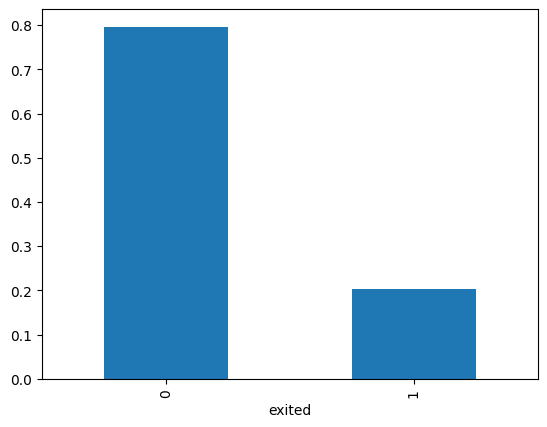

In [26]:
# Посчитаем процентное соотношение классов по тренировочной выборке
class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)

# Построим гистограмму
class_frequency.plot(kind='bar')

У обучающией выборки наблюдается заметный дисбаланс класов по факту ухода клиентов. 79% - клиентов осталось("0"), 21% - клинетов ушло ("1").

### Устранение дисбаланса

Для устранения дисбаланса классов в данных мы будем использовать следующие подходы:

*  **Взвешивание классов**: задаём модели веса для каждого класса, чтобы учесть дисбаланс и увеличить вклад меньшинств.
*   **Уменьшение выборки (undersampling)**: сокращаем количество данных для доминирующего класса, чтобы уравновесить распределение.
*   **Увеличение выборки (oversampling)**: добавляем больше данных для меньшинства, дублируя существующие записи или используя методы аугментации.
*   **Генерация синтетических данных**: создаём искусственные данные для меньшинств с помощью алгоритмов, таких как SMOTE (Synthetic Minority Oversampling Technique).



Создадим функцию для **уменьшения доли отрицательных ответов**.

Для этого необходимо сделать следующее:

+ Разделим обучающую выборку на отрицательные и положительные объекты;

+ Случайным образом отбросим часть из отрицательных объектов;

+ С учётом полученных данных создадим новую обучающую выборку;

+ Перемешаем данные;

+ Обучим модели на основе сбалансированной выборки.

In [27]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)

    return features_downsampled, target_downsampled

Создадим функцию для **увеличения доли отрицательных ответов**.

Для этого необходимо сделать следующее:

+ Разделим обучающую выборку на отрицательные и положительные объекты;

+ Скопируем несколько раз положительные объекты;

+ С учётом полученных данных создадим новую обучающую выборку;

+ Перемешаем данные;

+ Обучим модели на основе сбалансированной выборки.

In [28]:
# создадим функцию для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)

    return features_upsampled, target_upsampled

В качестве тестирования методов устранения дисбаланса будет использовать следующие модели:

*   LogisticRegression;
*   DecisionTreeClassifier;
*   RandomForestClassifier;
*   XGBClassifier.


In [29]:
# создадим функцию, которая будет проверять модели с учетом разных методов борьбы с дисбалансом
def evaluate_model(model, X_train, X_valid, y_train, y_valid, balance_method=None):

    # Создаем копии данных
    X_train_balanced = X_train.copy()
    y_train_balanced = y_train.copy()

    # Подготовка данных в зависимости от метода балансировки
    if balance_method == 'class_weight':
        if model == 'XGBClassifier':
                model.set_params(scale_pos_weight = len(y_train_balanced[y_train_balanced == 0]) / len(y_train_balanced[y_train_balanced == 1]))
        elif hasattr(model, 'class_weight'):
                model.set_params(class_weight='balanced')

    elif balance_method == 'downsample':
        X_train_balanced, y_train_balanced = downsample(X_train, y_train, 0.25)

    elif balance_method == 'upsample':
        X_train_balanced, y_train_balanced = upsample(X_train, y_train, 4)

    elif balance_method == 'smote':
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Обучение модели
    model.fit(X_train_balanced, y_train_balanced)

    # Предсказания
    y_pred = model.predict(X_valid)

    # Расчет метрик
    metrics = {
        'model': model.__class__.__name__,
        'balance_method': balance_method if balance_method else 'none',
        'recall': recall_score(y_valid, y_pred),
        'precision': precision_score(y_valid, y_pred),
        'f1': f1_score(y_valid, y_pred),
        'auc_roc': roc_auc_score(y_valid, y_pred)
    }

    return metrics

# Создадим список моделей для тестирования
models = [
    LogisticRegression(random_state=42, solver='liblinear'),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(eval_metric='logloss', random_state=42)
]

# Список методов балансировки
balance_methods = [None, 'class_weight', 'downsample', 'upsample', 'smote']

# Создадим список для хранения результатов
results = []

# Тестируем каждую модель с каждым методом балансировки
for model in models:
    for method in balance_methods:
        try:
            metrics = evaluate_model(
                model=model,
                X_train=features_train,
                X_valid=features_valid,
                y_train=target_train,
                y_valid=target_valid,
                balance_method=method
            )
            results.append(metrics)
        except Exception as e:
            print(f"Ошибка для модели {model.__class__.__name__} с методом {method}: {str(e)}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

# Округляем числовые значения для лучшей читаемости
numeric_columns = ['recall', 'precision', 'f1', 'auc_roc']
results_df[numeric_columns] = results_df[numeric_columns].round(3)

# Стилизация таблицы
styled_df = results_df.style.background_gradient(subset=numeric_columns, cmap='YlOrRd')\
    .highlight_max(subset=numeric_columns, color='lightgreen')\
    .format(precision=3)

# Выводим результаты
print("\nСравнительная таблица моделей:")
display(styled_df)


Сравнительная таблица моделей:


,model,balance_method,recall,precision,f1,auc_roc
0,LogisticRegression,none,0.223,0.619,0.328,0.594
1,LogisticRegression,class_weight,0.745,0.399,0.520,0.729
2,LogisticRegression,downsample,0.755,0.401,0.523,0.733
3,LogisticRegression,upsample,0.745,0.398,0.519,0.728
4,LogisticRegression,smote,0.699,0.399,0.508,0.714
5,DecisionTreeClassifier,none,0.505,0.486,0.495,0.684
6,DecisionTreeClassifier,class_weight,0.500,0.496,0.498,0.685
7,DecisionTreeClassifier,downsample,0.728,0.354,0.476,0.693
8,DecisionTreeClassifier,upsample,0.483,0.485,0.484,0.676
9,DecisionTreeClassifier,smote,0.615,0.456,0.524,0.714


Лучше всего показала себя модель **Random Forest** с методом устранения дисбаланса **upsample**

## Улучшение качества модели

Для начала подготовим данные для обучения. Применим метод **Upsample** для тренировочной выборки.

In [30]:
X_train_balanced, y_train_balanced = upsample(features_train, target_train, 2) # если сильно увеличиваем, то модель переобучается

Найдем наилучшие гиперпараметры для модели **RandomForest**

Осуществим подбор гиперпараметрова через модуль **RandomizedSearchCV**

In [31]:
param_dist = {
    'n_estimators': range(100, 500, 50),
    'max_depth': range(3, 15),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'max_features': ['sqrt', 'log2']
}
# Создаем модель
rf = RandomForestClassifier(random_state=42, bootstrap=True)


# Случайный поиск
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Обучаем модель
random_search.fit(X_train_balanced, y_train_balanced)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
print("Лучший f1-score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 13}
Лучший f1-score: 0.8199097154918416


### Обучение финальной модели

In [32]:
# Обучение финальной модели с лучшими параметрами
best_params = random_search.best_params_
final_model = RandomForestClassifier(**best_params, random_state=42, bootstrap=True)
final_model.fit(X_train_balanced, y_train_balanced)

# Оценка на валидационной выборке
predictions = final_model.predict(features_valid)
print("\nМетрики на валидационной выборке:")
print("Полнота:", recall_score(target_valid, predictions))
print("Точность:", precision_score(target_valid, predictions))
print("F1-мера:", f1_score(target_valid, predictions))
print("AUC-ROC:", roc_auc_score(target_valid, predictions))


Метрики на валидационной выборке:
Полнота: 0.5686274509803921
Точность: 0.6803519061583577
F1-мера: 0.6194926568758344
AUC-ROC: 0.7500800571484876


### Проверка финальной модели на адекватность

In [33]:
# Создадим константную модель
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.value_counts()

,count
0,2000


In [34]:
# Сравним показатели accuracy_score и AUC-ROC константной модели и финальной
print('f1_score константой модели:', f1_score(target_valid, target_predict_constant))
print('f1_score финальной модели:', f1_score(target_valid, predictions))
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_valid, predictions))

f1_score константой модели: 0.0
f1_score финальной модели: 0.6194926568758344
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.7500800571484876


Финальную модель можно считать адекватной, т.к. её показатели выше показателей константной модели.

**Выводы:**

+ в первоначальных данных наблюдался дисбаланс. Методом upsampling мы его устранили;


+ На сбалансированных данных модели показали результат лучше, чем на несбалансированных данных;


+ Наблюдается переобучение модели. Нужно больше данных, чтобы модель не переобучалась;


+ Финальная модель прошла проверку на адекватность.

## Тестирование модели

In [35]:
# Замерим метрики по тестовой выборке
RandomForest_prediction_final_test = final_model.predict(features_test)
print("\nМетрики на Тестовой выборке:")
print("Полнота" , recall_score(target_test, RandomForest_prediction_final_test))
print("Точность", precision_score(target_test, RandomForest_prediction_final_test))
print("F1-мера", f1_score(target_test, RandomForest_prediction_final_test))
print("AUC-ROC", roc_auc_score(target_test, RandomForest_prediction_final_test))


Метрики на Тестовой выборке:
Полнота 0.5282555282555282
Точность 0.6677018633540373
F1-мера 0.5898491083676268
AUC-ROC 0.7305433322382475


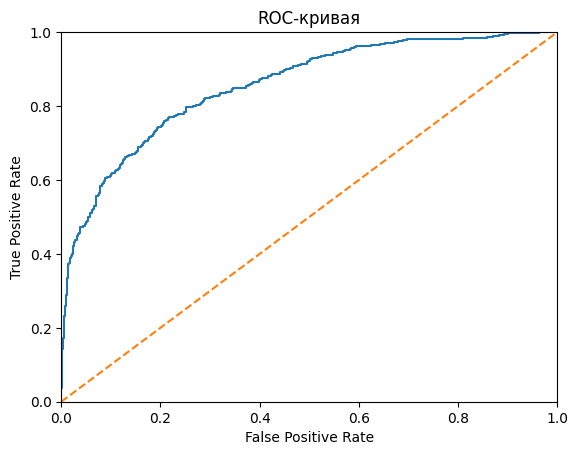

In [36]:
# Построим ROC-кривую финальной модели по тестовой выборке
final_model_probabilities_one = final_model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()